# Sprint 2: Unsupervised learning

## Data Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re, string

rows_to_read = 5000 # Gewenst aantal rijen inlezen (None = allemaal)

complaints = pd.read_csv('../data/complaints.csv', delimiter=',', nrows=rows_to_read)

rows, cols = complaints.shape

In [4]:
complaints.Product.unique()
complaints['Product'].nunique()

10

In totaal zijn er 9 verschillende producten, daarom is het doel om uiteindelijk 9 clusters te bekomen die elk
een product categorie voorstellen.

In [5]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


# 3. DBSCAN

**DBSCAN - Density-Based Spatial Clustering**. Bepaald de belangrijkste samples met een hoge densiteit en expandeert clusters van hen. Het is populair vanwege zijn flexibiliteit en variërende cluster grotes en vormen, maar ook door zijn robusheid tegen grensgevallen (outliers). 

### 3A. Data pre-processing

In [6]:
# pip install nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def processing(string):
    # omzetten naar lowercase 
    string = string.lower()
    # alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]', '', string)
    # alle getallen eruit filteren
    string = re.sub(r'[0-9]|,', '', string)
    # returns en newlines eruithalen
    string = string.replace('\r', ' ')
    string = string.replace('\n', ' ')
    # kaartnummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}', ' ', string)
    # de string splitten om de stopwoorden er afzonderlijk uit te halen
    tokens = string.split(' ')
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS and len(w) > 3]
    ## werkwoord vervoegingen veranderen en woorden reduceren naar stamvorm
    result = [SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    return result

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
complaints_df['Narrative_Processed'] = complaints_df['Narrative'].apply(processing)

### 3B. Tf-idf Vectorizer

De matrix waarop DBSCAN wordt uitgevoerd wordt bekomen via een TF-idf vectorizer.
Elke rij komt overeen met een complaint, en de kolommen in de complaint geven de frequentie van het overeenkomstige woord aan.

* **max_df** : de maximum frequency die een feature kan hebben om gebruikt te worden in de tdi-idf matrix
* **min_df**: het minimum aantal aanwezige documenten
* **ngram_range**: kijken naar unigrams, bigrams etc..

Tf-idf is al reeds rij genormaliseerd

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

#woorden die in meer dan 95% van de narratives voorkomen en woorden die in 5 of minder narratives voorkomen negeren 
#ook bigrams in rekening nemen
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),
                                    min_df = 20, 
                                    max_df = .50,
                                    max_features=50 )

#dit zijn alle features
X = tfidf_vectorizer.fit_transform(tokens)
X_array = X.toarray()
#target
y = complaints_df.head(10000)['Product'].values

# print(X.shape)
#print(y.shape)
print(X.toarray())

[[0.         0.         0.         ... 0.         0.14893297 0.1969194 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.19427017 0.51372862]
 ...
 [0.         0.         0.         ... 0.         0.15959817 0.21102094]
 [0.         0.10394421 0.         ... 0.2331621  0.12261607 0.        ]
 [0.         0.08719149 0.         ... 0.07823332 0.06856933 0.        ]]


In [18]:
feature_names=tfidf_vectorizer.get_feature_names()
print(feature_names[:10])
print(len(feature_names))
# #documenten,#features names (woorden in woordenboek)
print(X.shape)


['agenc', 'ask', 'balanc', 'bank', 'block', 'call', 'card', 'charg', 'check', 'claim']
50
(5000, 50)


### 3C. Toepassen DBSCAN - niet genormaliseerd

Bepalen van de parameters:

**min_samples**: bepaald vanaf wanneer een groep samples kan worden beschouwd als cluster, één van de belangrijkste taken van deze parameter is dus het verwijderen van outliers. Een algemene vuistregel die we initieel toepassen is als volgt: het minimum aantal punten zou groter of gelijk moeten zijn aan de dimensie van onze dataset. Typisch nemen mensen die DBSCAN gebruiken, minimum twee maal de data dimensie, 2*d. Hoe meer ruis in onze data hoe groter we deze parameter moeten kiezen.


In [19]:
# Bepalen van min_samples
dim=X.shape[1]
min_samples = 2*dim

**eps**: legt vast hoe dicht punten bij elkaar zouden moeten liggen om als deel van een cluster beschouwd te worden. Het betekent dat als een distance tussen twee punten lager of gelijk is aan deze value, dan zijn deze punten buren.

Berkenen van de cosine distances tussen de complaints

In [20]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X.shape[0]+1):
    cosine_similarities.append(linear_kernel(X[i-1:i], X).flatten())
dist_df=pd.DataFrame(cosine_similarities)

Voor elk punt in de dataset hebben we de distances ten opzichte van de andere punten bepaald.
Sinds we onze punten in stijgende volgorde hebben gesorteerd kunnen we eps bepalen met de elbow methode.
De keuze voor epsilon zal op de hoogte van de elleboog komen te liggen.

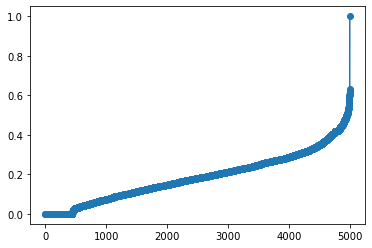

In [21]:
import matplotlib.pyplot as plt
dist_df_sorted = dist_df.sort_values([0], ascending = (True))
plt.plot(range(0,X.shape[0]), dist_df_sorted[0],marker='o')

In [29]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.5, min_samples=20).fit(dist_df_sorted)

#Storing the labels formed by the DBSCAN
labels = db.labels_

In [ ]:
# Run DBSCAN with essay1
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels1 = db.labels_
n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
print(labels1)
print()

clusters1 = {}
for c, i in enumerate(labels1):
    if i == -1:
        continue
    elif i in clusters1:
        clusters1[i].append( X_array[c] )
    else:
        clusters1[i] = [X_array[c]]
for c in clusters1:
    print(clusters1[c])
    print()

[ 0 -1  0 ... -1 -1 -1]
['y', 'b', 'g', 'r']


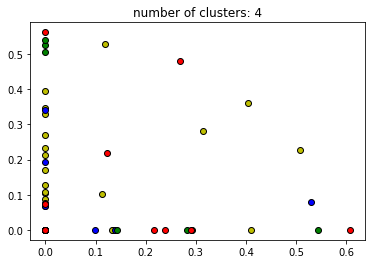

In [31]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 
  
# Number of clusters in labels, ignoring noise if present. 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
  
print(labels) 
  
# Plot result 
import matplotlib.pyplot as plt 
  
# Black removed and is used for noise instead. 
unique_labels = set(labels) 
colors = ['y', 'b', 'g', 'r'] 
print(colors) 
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
  
    class_member_mask = (labels == k) 
  
    xy = X_array[class_member_mask & core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=6) 
  
    xy = X_array[class_member_mask & ~core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=6) 
  
plt.title('number of clusters: %d' %n_clusters_) 
plt.show() 

### 3D. Toepassen DBSCAN - genormaliseerd

De bekomen resultaten zijn niet wat verwacht is, daarom wordt overgeschakeld naar een genormaliseerde dataset.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = complaints_df['Narrative_Processed'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),
                                    min_df = 3, 
                                    max_df = .2)

#dit zijn alle features
X2= tfidf_vectorizer.fit_transform(tokens)
X2_array = X2.toarray()
#target
y2 = complaints_df.head(10000)['Product'].values

print(X2.shape)
print(y2.shape)

(5000, 32227)
(5000,)


In [19]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
X2_fitted=svd.fit_transform(X2)

In [20]:
X2_fitted.shape

(5000, 50)

In [21]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities=[]
for i in range(1,X2_fitted.shape[0]+1):
    cosine_similarities.append(linear_kernel(X2_fitted[i-1:i], X2_fitted).flatten())
dist_df2=pd.DataFrame(cosine_similarities)

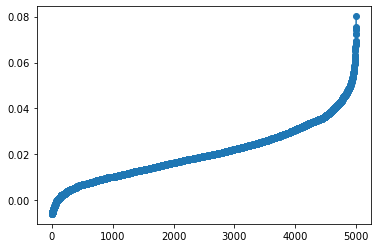

In [22]:
import matplotlib.pyplot as plt
dist_df2_sorted = dist_df2.sort_values([0], ascending = (True))
plt.plot(range(0,X2_fitted.shape[0]), dist_df2_sorted[0],marker='o')

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np
db = DBSCAN(eps=0.5, min_samples=20)
db_X=db.fit_predict(X2_fitted)

#Storing the labels formed by the DBSCAN
labels = db.labels_

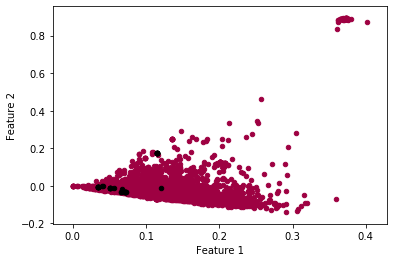

In [24]:
plotClusters2D(X2_fitted,db_X)